In [2]:
import numpy as np
import pandas as pd  
import xarray as xr 
import matplotlib.pyplot as plt 

In [3]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [4]:
def get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9)):
    # analyze error source
    RMSE = []
    amp_err  = []
    pha_err = []
    BCC = []

    # define the selected time series, inclusive
    tsta = np.datetime64(str(testyrsta)) + np.timedelta64(nmem-1, 'D')
    tend = np.datetime64(str(testyrend)) - np.timedelta64(1, 'D')

    # RMM index in all seasons, amplitudes and phases.
    fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
    dsrmm0 = xr.open_dataset(fnRMM)
    # delete doy 366
    # dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
    dsrmm = dsrmm0.sel(time=slice(tsta, tend))

    
    RMMi1 = dsrmm['RMM'][:,0]
    RMMi2 = dsrmm['RMM'][:,1]

    # calculate initial amplitude
    Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

    # calculate initial phase
    Inipha = np.zeros(len(RMMi1))

    for i in np.arange(len(RMMi1)):
        Inipha[i] = get_phase(RMMi1[i].values,RMMi2[i].values)
     
    Inipha = xr.DataArray(
        data=Inipha,
        dims=['time'],
        coords=dict(
            time=Iniamp.time,
        ),
    ) 

    time_len0 = len(Iniamp.time)

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 

        fn = './output/predicted_MCDO_UNET_olr20deg_RMMERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'

        dsfn0 = xr.open_dataset(fn)
        dsfn = dsfn0.sel(time=slice(tsta, tend))

        # RMMp, RMMt, RMMp_dis in all seasons, amplitudes and phases. 
        # add Initial amplitude and phase information into the dataset.

        # check whether they have the same length.
        time_len1 = len(dsfn['time'])

        assert time_len0 == time_len1, f"Time lengths in RMM raw file and predcition are different"

        # assign variables to dsfn
        dsfn = dsfn.assign(IniAmp=Iniamp)
        dsfn = dsfn.assign(IniPha=Inipha)
        dsfn['RMMt'][:] = dsrmm0.sel(time=slice(tsta+np.timedelta64(leadmjo, 'D'), tend+np.timedelta64(leadmjo, 'D')))['RMM'].values

        # select a subset of dsfn based on seasons, Initial amplitude threshold and initial phase. 
        # mask_season = pd.to_datetime(dsfn.time).month.isin(season_list)
        mask_season = dsfn.time.dt.month.isin(season_list)
        mask_Iniamp = dsfn.IniAmp >= Iniamp0
        mask_Inipha = dsfn.IniPha.isin(Inipha_list)

        mask = mask_season & mask_Iniamp & mask_Inipha

        dsfn_sel = dsfn.where(mask, drop=True)

        # calculate BCC for each MCDO
        r1p = np.asarray(dsfn_sel['RMMp'][:,0]).reshape((-1, 1))
        r2p = np.asarray(dsfn_sel['RMMp'][:,1]).reshape((-1, 1))

        r1t = np.asarray(dsfn_sel['RMMt'][:,0]).reshape((-1, 1))
        r2t = np.asarray(dsfn_sel['RMMt'][:,1]).reshape((-1, 1))

        # # calculate BCC for each MCDO
        # r1p = np.asarray(dsfn_sel['RMMp'][:,0])
        # r2p = np.asarray(dsfn_sel['RMMp'][:,1])

        # r1t = np.asarray(dsfn_sel['RMMt'][:,0])
        # r2t = np.asarray(dsfn_sel['RMMt'][:,1])

        # print(np.shape(r1p))
        # print(np.shape(r2t))

        # BCC  [Nsamp]
        a = np.sum(r1p*r1t+r2p*r2t, axis=0)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t, axis=0))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE [time, Nsamp]
        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        RMSE.append(np.sqrt(d))  # RMSE at each time step

        # phase error [time, Nsamp]
        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        pha_err.append(d)

        # amplitude error [time, Nsamp] truth - prediction
        a = np.sqrt(r1p*r1p+r2p*r2p)
        b = np.sqrt(r1t*r1t+r2t*r2t)
        c = b - a 
        amp_err.append(c)

        del dsfn 
        del dsfn_sel

    return BCC, RMSE, pha_err, amp_err

In [5]:
# calculate BCC for models using individual wnx (0,1,...,20)
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCC_one = []
RMSE_one = []
wnxflg = 'one'

for wnx in np.arange(21):
    BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCC2),np.mean(RMSE2))
    BCC_one.append(np.mean(BCC2))
    RMSE_one.append(np.mean(RMSE2))


0.13832272936022816 1.4833624142505177
0.5569501196865656 1.143738149497083
0.3864729541933251 1.2982439284634928
0.20993624999317975 1.3998686036382093
0.1606103203999298 1.4395381214195526
0.04919235880573663 1.4995600012717476
0.0876537654221462 1.484627866362416
0.11893595961346956 1.4625349896580973
0.07233982879272625 1.4842946541227164
0.05261471016559423 1.5016704847369626
0.04429971231969702 1.4896162797952706
0.0636530167366257 1.4875258011660344
0.036440698719818594 1.511248971313815
0.026676928293290197 1.515805893525326
0.053787933277083325 1.4916350582892166
0.04937831644231053 1.4891951986762835
0.05169568998707146 1.486173665149898
0.02506887736758635 1.5090711440557436
0.07721300110299184 1.4852291112913472
0.04279108656924664 1.4981575163061052
0.10589315233835243 1.4611493498012667


In [6]:
# calculate BCC for models using all wnx (0-wnx)
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCC_all = []
RMSE_all = []
wnxflg = 'all'

for wnx in [1,2,4,5,6,7,10]:
    BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCC2),np.mean(RMSE2))
    BCC_all.append(np.mean(BCC2))
    RMSE_all.append(np.mean(RMSE2))

0.5871516974678403 1.1179455083571408
0.6208906614089861 1.087710420257667
0.6406177344336729 1.0664365188713676
0.6614790210295498 1.04295779786998
0.6428316249637934 1.0630867017224452
0.6592388505162068 1.0449646711778606
0.6505617371071889 1.0534664725140128


In [7]:
# calculate BCC for models using 1-wnx (no mean)
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCC_no0 = []
RMSE_no0 = []
wnxflg = 'no0'

for wnx in np.arange(2,11):
    BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCC2),np.mean(RMSE2))
    BCC_no0.append(np.mean(BCC2))
    RMSE_no0.append(np.mean(RMSE2))



0.6032066684076903 1.1099604600419506
0.6133654626730407 1.1049036677865938
0.6205996352807597 1.0928807010718213
0.6394526065425954 1.0700909738030355
0.6348823676019861 1.072629484112251
0.6378054367796285 1.0676481501401835
0.6367626834220188 1.0682122705970052
0.6347201338052609 1.0670565282125979
0.6410808839999371 1.064253981538317


In [8]:
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCCresi = []
RMSEresi = []
wnxflg = 'resi'

for wnx in [5,10,20,50]:
    BCCresi0, RMSEresi0, pha_errresi0, amp_errresi0 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCCresi0),np.mean(RMSEresi0))
    BCCresi.append(BCCresi0)
    RMSEresi.append(RMSEresi0)

0.5711325473054789 1.1320434049033448
0.5508692131502783 1.153953646534507
0.5365676449315233 1.167002951505225
0.4698293309687019 1.218830472988095


In [9]:
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCC = []
wnxflg = 'off'

wnx = 1
BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
print(np.mean(BCC),np.mean(RMSE))

0.6716283647043021 1.0238106464891934


In [22]:
# get BCC for simulations only with meridional projection (without Mode 0)
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
wnx = 1
mflg = 'no1'

BCCmno1 = []
wnxflg = 'off'

for m in [3,4,5]:
    BCCmno10, RMSEmno10, pha_errmno10, amp_errmno10 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCCmno10),np.mean(RMSEmno10))
    BCCmno1.append(np.mean(BCCmno10))



0.4903699678555633 1.2096651037518047
0.46999064390338724 1.2187010799109783
0.4991184439064469 1.200596835715816


In [14]:
# get BCC for simulations only with meridional projection (residual of sum(0-4))
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
wnx = 1
mflg = 'resi'

BCCmresi = []
wnxflg = 'off'

for m in [5]:
    BCCmno10, RMSEmno10, pha_errmno10, amp_errmno10 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(np.mean(BCCmno10),np.mean(RMSEmno10))
    BCCmresi.append(np.mean(BCCmno10))

0.5682598293723264 1.1366169996546311


In [20]:
# Y projection, mflg = 'one'
BCC_mone = [0.5957631274729966, 0.2897589331750929, 0.36960283323609827, 0.30247127212292346, 0.33621980026207215]

In [28]:
# Y projection, mflg = 'all'
BCC_mall = [0.590268343040865, 0.6303328450810097, 0.6541144724432602, 0.6422053412004681, 0.6626185342611117]

In [ ]:
# Y projection, m = 5, mflg = 'resi'


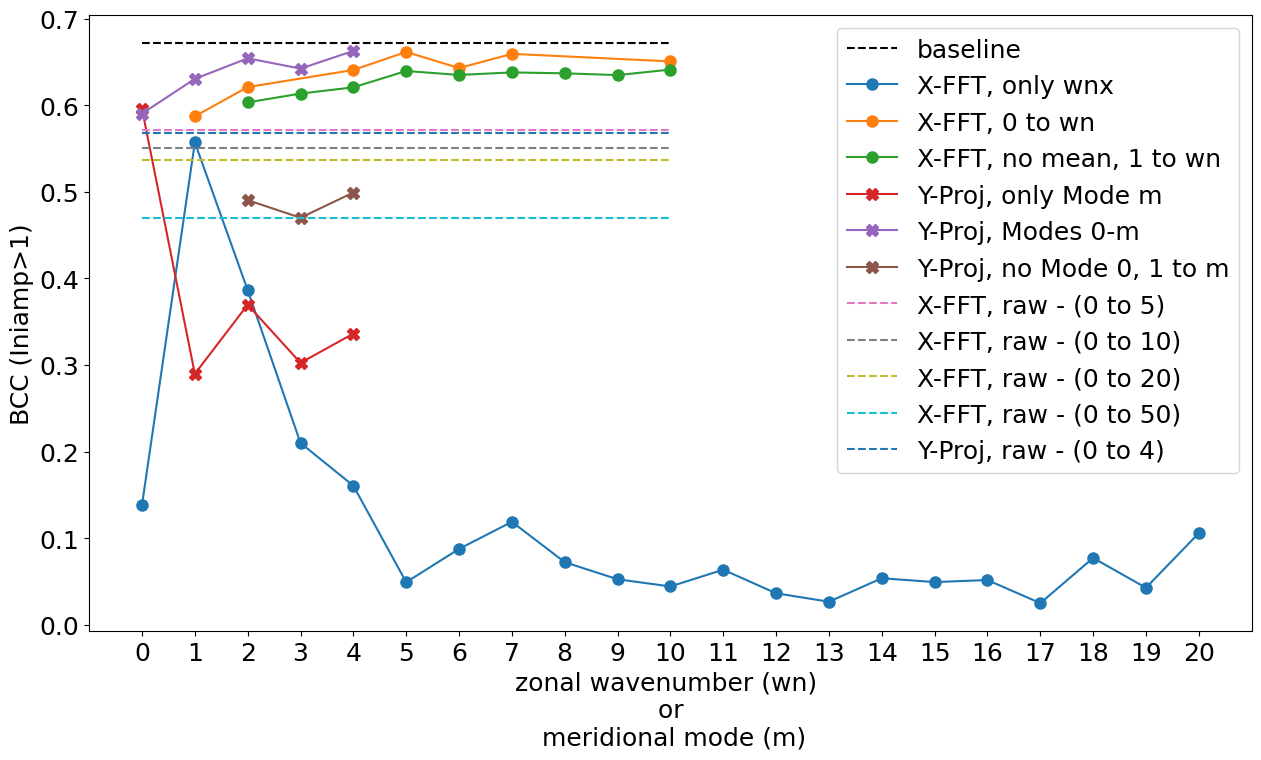

In [30]:
# plot all simulation BCC together
fig, ax = plt.subplots(1,1)
fig.set_figwidth(15)
fig.set_figheight(8)

ax.plot(np.arange(11), np.ones(11)*np.mean(BCC), 'k--', label='baseline')
ax.plot(np.arange(21), BCC_one,'o-',label='X-FFT, only wnx', markersize=8)
ax.plot([1,2,4,5,6,7,10], BCC_all, 'o-', label='X-FFT, 0 to wn', markersize=8)
ax.plot(np.arange(2,11), BCC_no0,'o-',label='X-FFT, no mean, 1 to wn', markersize=8)

ax.plot(np.arange(5), BCC_mone,'X-',label='Y-Proj, only Mode m', markersize=8)
ax.plot(np.arange(5), BCC_mall,'X-',label='Y-Proj, Modes 0-m', markersize=8)
ax.plot([2,3,4], BCCmno1,'X-',label='Y-Proj, no Mode 0, 1 to m', markersize=8)
ax.plot(np.arange(11), np.ones(11)*np.mean(BCCresi[0]), '--', label='X-FFT, raw - (0 to 5)')
ax.plot(np.arange(11), np.ones(11)*np.mean(BCCresi[1]), '--', label='X-FFT, raw - (0 to 10)')
ax.plot(np.arange(11), np.ones(11)*np.mean(BCCresi[2]), '--', label='X-FFT, raw - (0 to 20)')
ax.plot(np.arange(11), np.ones(11)*np.mean(BCCresi[3]), '--', label='X-FFT, raw - (0 to 50)')
ax.plot(np.arange(11), np.ones(11)*np.mean(BCCmresi), '--', label='Y-Proj, raw - (0 to 4)')

ax.set_xlabel('zonal wavenumber (wn) \n or \n meridional mode (m)')
ax.set_xticks(np.arange(21))
ax.set_ylabel('BCC (Iniamp>1)')
plt.rcParams.update({'font.size': 18})
ax.legend()


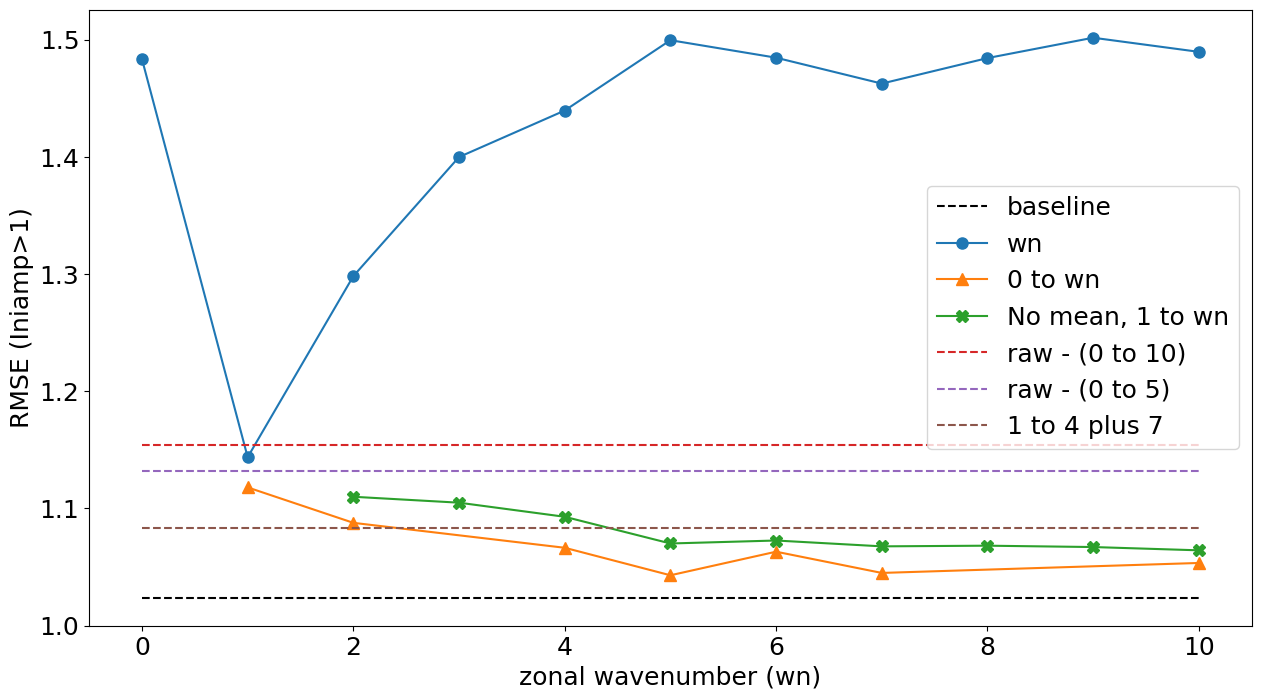

In [15]:
# plot all simulation BCC together
fig, ax = plt.subplots(1,1)
fig.set_figwidth(15)
fig.set_figheight(8)

ax.plot(np.arange(11), np.ones(11)*np.mean(RMSE), 'k--', label='baseline')
ax.plot(np.arange(11), RMSE_one,'o-',label='wn', markersize=8)
ax.plot([1,2,4,5,6,7,10], RMSE_all, '^-', label='0 to wn', markersize=8)
ax.plot(np.arange(2,11), RMSE_no0,'X-',label='No mean, 1 to wn', markersize=8)
ax.plot(np.arange(11), np.ones(11)*np.mean(RMSEresi), '--', label='raw - (0 to 10)')
ax.plot(np.arange(11), np.ones(11)*np.mean(RMSEresi5), '--', label='raw - (0 to 5)')
ax.plot(np.arange(11), np.ones(11)*np.mean(RMSEno0p7), '--', label='1 to 4 plus 7')
ax.set_xlabel('zonal wavenumber (wn)')
ax.set_ylabel('RMSE (Iniamp>1)')
plt.rcParams.update({'font.size': 18})
ax.legend(loc='center right')


In [8]:
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'one'

BCC = []
wnxflg = 'all'

wnx = 1
BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
print(BCC2)

wnx = 2
BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
print(BCC2)

wnx = 10
BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
print(BCC2)


[array([0.58642869])]
[array([0.59049251])]
[array([0.52458748])]


[array([0.60320667])]
[array([0.61336546])]
[array([0.62059964])]
[array([0.63945261])]
[array([0.63488237])]
[array([0.63780544])]
[array([0.63676268])]
[array([0.63472013])]
[array([0.64108088])]


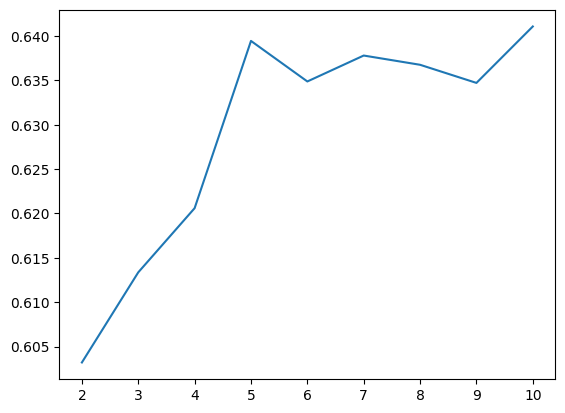

In [5]:
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'

BCC = []
wnxflg = 'no0'

for wnx in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
    print(BCC2)
    BCC.append(BCC2)

plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10], np.asarray(BCC).squeeze())

Text(0.5, 1.0, 'No mean, OLR 20deg, lead=10')

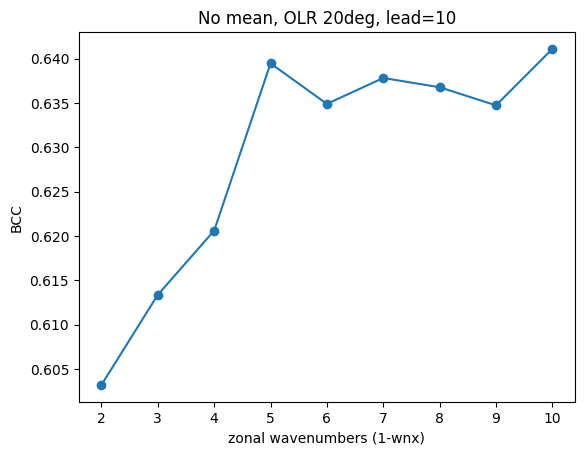

In [7]:
plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10], np.asarray(BCC).squeeze(),'o-')
plt.xlabel('zonal wavenumbers (1-wnx)')
plt.ylabel('BCC')
plt.title('No mean, OLR 20deg, lead=10')

In [10]:
# lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
lead = [10,]
testyrsta = 2015
testyrend = 2020
nmem = 1
m = 1
mflg = 'off'
wnxflg = 'all'

# wnx = 1
# BCC1, RMSE1, pha_err1, amp_err1 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
# wnx = 2
# BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
# wnx = 10
# BCC10, RMSE10, pha_err10, amp_err10 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))

# print(BCC1, BCC2, BCC10)

wnxflg = 'one'
wnx = 2
BCC2, RMSE2, pha_err2, amp_err2 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
wnx = 0
BCC0, RMSE0, pha_err0, amp_err0 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
wnx = 1
BCC1, RMSE1, pha_err1, amp_err1 = get_BCC_RMSE(m, mflg, wnx, wnxflg, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=1, Inipha_list=np.arange(1,9))
print(BCC0, BCC1, BCC2)

[array([0.13832273])] [array([0.55695012])] [array([0.38647295])]


In [5]:
def get_figure(ax, lead, BCC, label_flg, RMSE, amp_err, pha_err):
    ax[0,0].plot(lead, BCC, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,0].plot(lead, BCCw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,0].plot(lead, 0.5 * np.ones(len(lead)), '--', color='k')
    ax[0,0].grid(visible=True)
    ax[0,0].set_xlabel('lead (days)')
    ax[0,0].set_ylabel('BCC')
    # ax[0,0].legend()

    avRMSE = np.mean(RMSE, axis=1)
    # avRMSEw = np.mean(RMSEw, axis=1)

    ax[0,1].plot(lead, avRMSE, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, avRMSEw, 'o-', linewidth=3, label='DJFM, Iniamp>1, All Inipha')
    ax[0,1].plot(lead, 1.2 * np.ones(len(lead)), '--', color='k')
    ax[0,1].grid(visible=True)
    ax[0,1].set_xlabel('lead (days)')
    ax[0,1].set_ylabel('RMSE')
    ax[0,1].legend(fontsize=12)

    avamperr = np.mean(amp_err, axis=1)
    # avamperr = np.mean(amp_err, axis=1)

    ax[1,1].plot(lead, avamperr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,1].grid(visible=True)
    ax[1,1].set_xlabel('lead (days)')
    ax[1,1].set_ylabel('Amplitude Error')
    # ax[1,1].legend()

    avphaerr = np.mean(pha_err, axis=1)

    ax[1,0].plot(lead, avphaerr, 'o-', linewidth=3, label=label_flg) #'All year, Iniamp>1, All Inipha')
    # ax[0,1].plot(lead, 1.2 * np.ones(len(lead)))
    ax[1,0].grid(visible=True)
    ax[1,0].set_xlabel('lead (days)')
    ax[1,0].set_ylabel('Phase Error (degree)')
    ax[1,0].set_ylim([-15, 15])
    # ax[1,0].legend()

FileNotFoundError: [Errno 2] No such file or directory: b'/global/u1/l/linyaoly/ERA5/script/Unet4MJO/1map_MCDO_RMM_ERA5_yproj_selectm_multiple/output/predicted_MCDO_UNET_olr20deg_RMMERA5_4modes1pls_lead30_dailyinput_1979to2015_mem1d.nc'

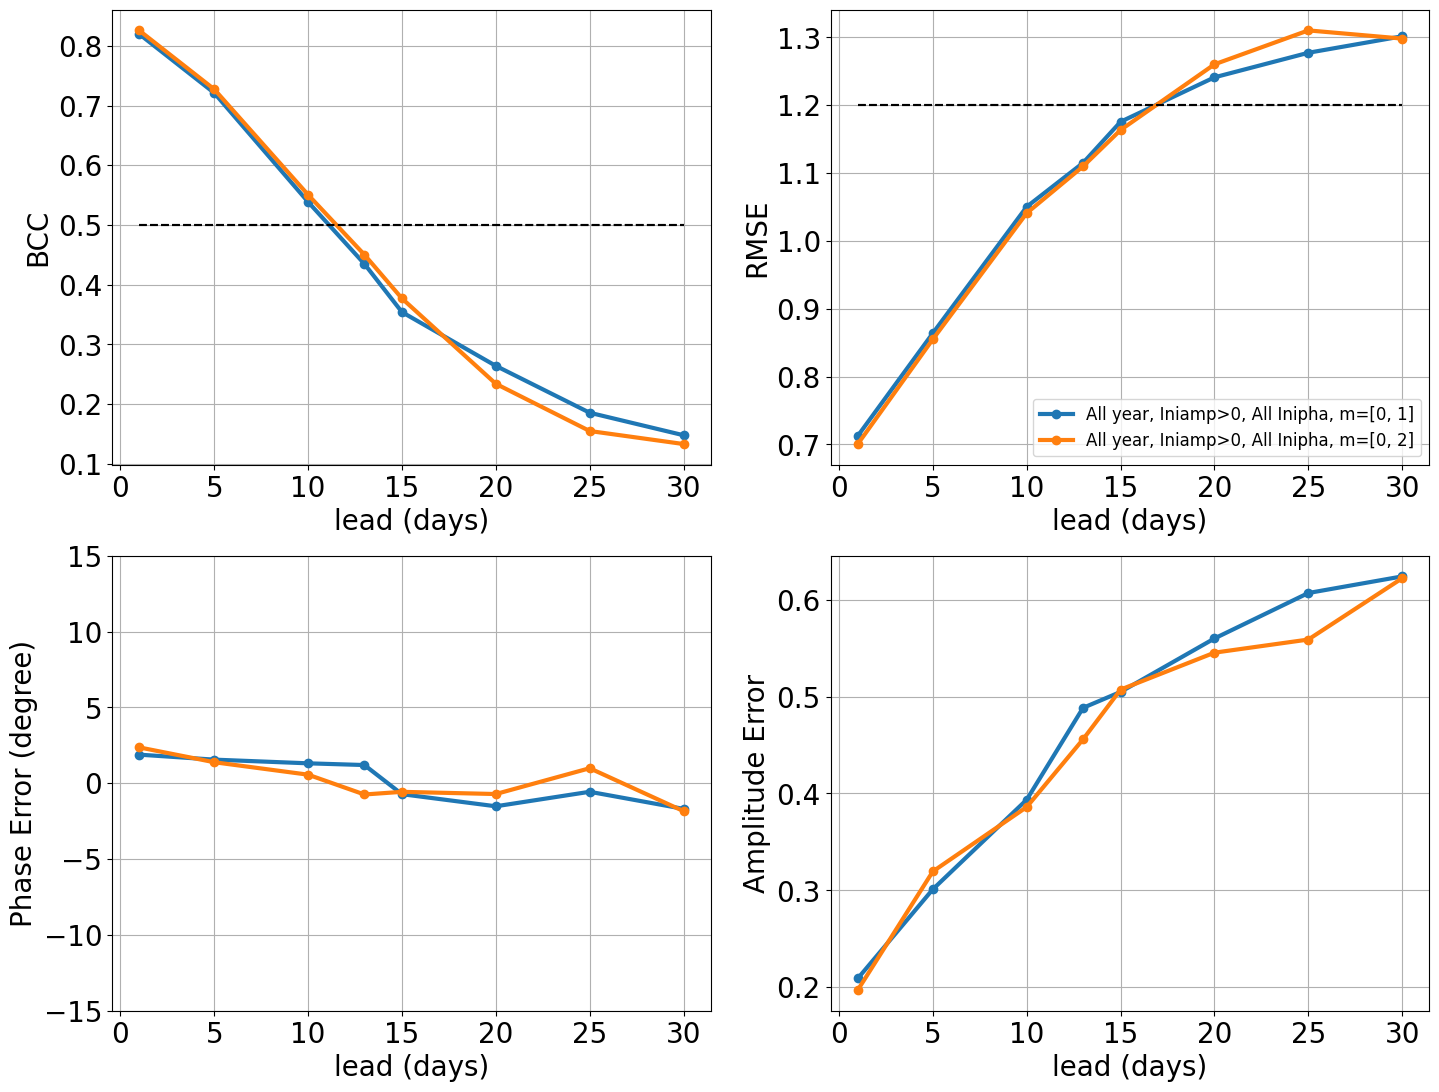

In [8]:
lead = [1, 5, 10, 13, 15, 20, 25, 30]   # select the prediction lead
testyrsta = 2015
testyrend = 2020
nmem = 1
Iniamp0 = 0
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(17,13))
gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

for m in np.arange(2,5):
    BCC, RMSE, pha_err, amp_err = get_BCC_RMSE(m, lead, testyrsta, testyrend, nmem, season_list=np.arange(1,13), Iniamp0=Iniamp0, Inipha_list=np.arange(1,9))
    get_figure(ax, lead, BCC, 'All year, Iniamp>'+str(Iniamp0)+', All Inipha, m=[0, '+str(m-1)+']', RMSE, amp_err, pha_err)


Text(0.5, 1.0, 'RMM2 2015, nmem=1, 1modesone_wnx1all_lead10')

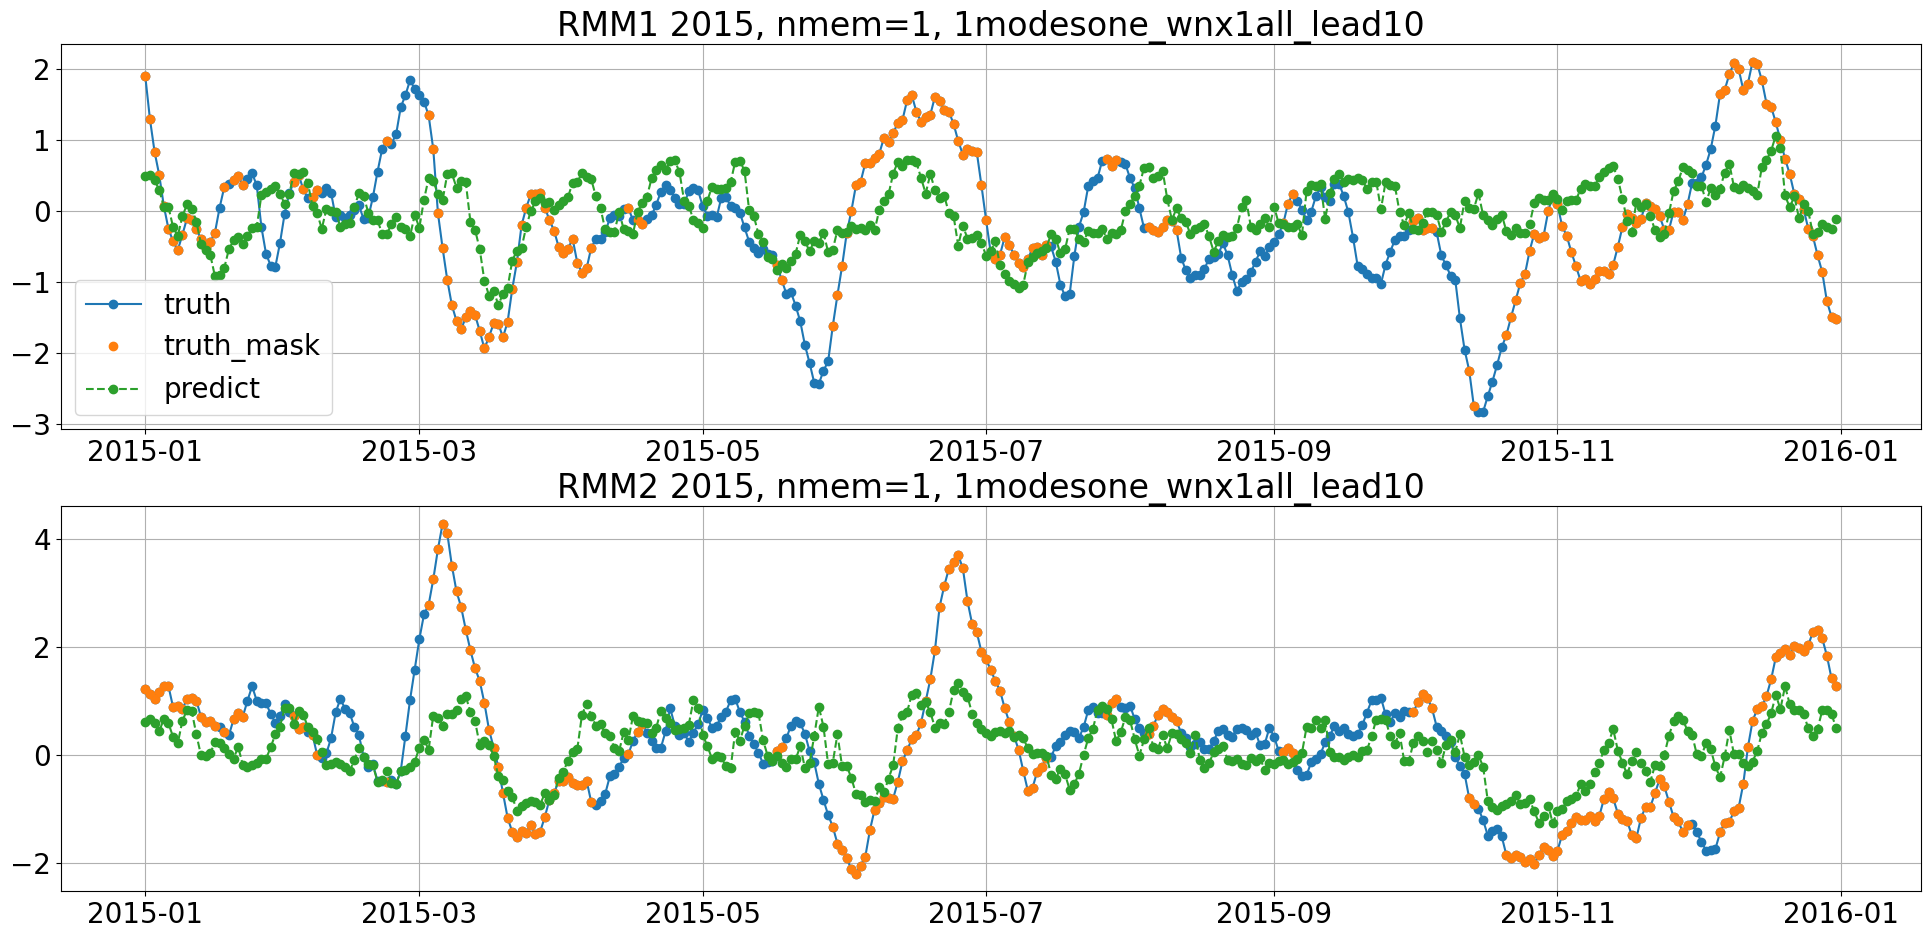

In [6]:
# show individual predictions
yr = 2015
leadmjo = 10
nmem = 1 
m = 1
Iniamp0 = 1
mflg='one'
wnx=1
wnxflg='all'

fn = './output/predicted_MCDO_UNET_olr20deg_RMMERA5_'+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo)+'_dailyinput_1979to2015_mem'+str(nmem)+'d.nc'
ds = xr.open_dataset(fn)

ds15 = ds.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))

# mark points where Iniamp > 1

# define the selected time series, inclusive
tsta = np.datetime64(str(yr)) + np.timedelta64(nmem-1, 'D')
tend = np.datetime64(str(yr+1)) - np.timedelta64(1, 'D')

# RMM index in all seasons, amplitudes and phases.
fnRMM = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
dsrmm0 = xr.open_dataset(fnRMM)
# delete doy 366
# dsrmm0 = dsrmm1.where(dsrmm1.time.dt.dayofyear!=366, drop=True)    
dsrmm = dsrmm0.sel(time=slice(tsta, tend))

RMMi1 = dsrmm['RMM'][:,0]
RMMi2 = dsrmm['RMM'][:,1]

# calculate initial amplitude
Iniamp = (RMMi1 * RMMi1 + RMMi2 * RMMi2)**(1/2)

ds15 = ds15.assign(IniAmp=Iniamp)

mask_Iniamp = ds15.IniAmp >= Iniamp0
ds15_mask = ds15.where(mask_Iniamp)

fig = plt.figure(figsize=(24,11))
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

ax[0].plot(ds15['time'], ds15['RMMt'][:,0],'o-', label='truth')
ax[0].plot(ds15_mask['time'], ds15_mask['RMMt'][:,0],'o', label='truth_mask')
ax[0].plot(ds15['time'], ds15['RMMp'][:,0],'o--', label='predict')
ax[0].legend()
ax[0].grid(visible=True)
ax[0].set_title('RMM1 '+ str(yr)+ ', nmem='+str(nmem)+', '+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo))

ax[1].plot(ds15['time'], ds15['RMMt'][:,1],'o-', label='truth')
ax[1].plot(ds15_mask['time'], ds15_mask['RMMt'][:,1],'o', label='truth_mask')
ax[1].plot(ds15['time'], ds15['RMMp'][:,1],'o--', label='predict')
# ax[1].legend()
ax[1].grid(visible=True)
ax[1].set_title('RMM2 '+ str(yr) + ', nmem='+str(nmem)+', '+str(m)+'modes'+mflg+'_wnx'+str(wnx)+wnxflg+'_lead'+str(leadmjo))

Text(0.5, 1.0, 'RMM2 2015')

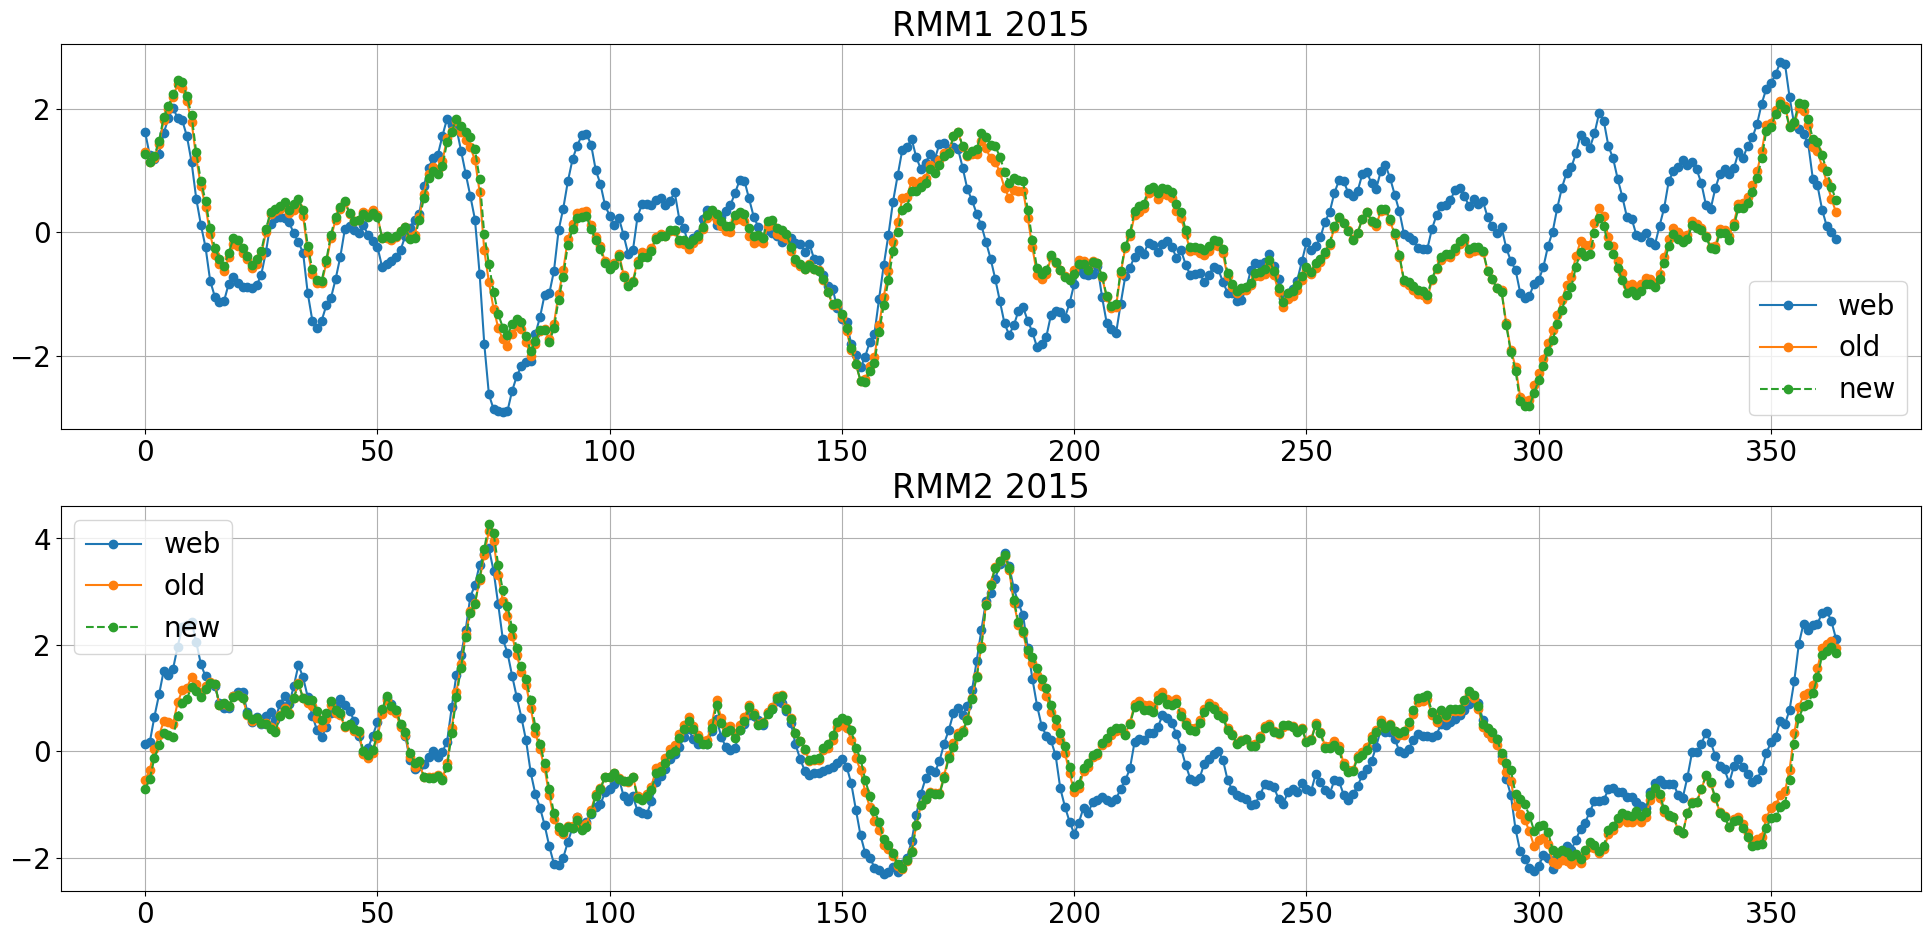

In [6]:
import pandas as pd 
# compare old RMM, new RMM with website RMM in 1979-2020 
fn1 = '/global/homes/l/linyaoly/ERA5/reanalysis/RMM_ERA5_daily.nc'
fn2 = '/pscratch/sd/l/linyaoly/ERA5/reanalysis/rmm/full/RMM_ERA5_daily_1901to2020.nc'
ds1 = xr.open_dataset(fn1)
ds2 = xr.open_dataset(fn2)

yr = 2015
ds115 = ds1.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))
ds215 = ds2.sel(time=slice(str(yr)+'-01-01',str(yr)+'-12-31'))

fn3 = '/global/homes/l/linyaoly/ERA5/reanalysis/realRMM/'+str(yr)+'.csv'
ds3 = pd.read_csv(fn3, sep=',', header=0)

fig = plt.figure(figsize=(24,11))
gs = fig.add_gridspec(2, 1, hspace=0.2, wspace=0.2)
ax = gs.subplots()
plt.rcParams.update({'font.size': 20})

ax[0].plot(ds3['RMM1'],'o-', label='web')
ax[0].plot(ds115['RMM'][:,0],'o-', label='old')
ax[0].plot(ds215['RMM'][:,0],'o--', label='new')

ax[0].legend()
ax[0].grid(visible=True)
ax[0].set_title('RMM1 '+ str(yr))

ax[1].plot(ds3['RMM2'],'o-', label='web')
ax[1].plot(ds115['RMM'][:,1],'o-', label='old')
ax[1].plot(ds215['RMM'][:,1],'o--', label='new')
ax[1].legend()
ax[1].grid(visible=True)
ax[1].set_title('RMM2 '+ str(yr))